# Symbolic regression example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
def target_function(X):
    return X**3 + X**2 + X

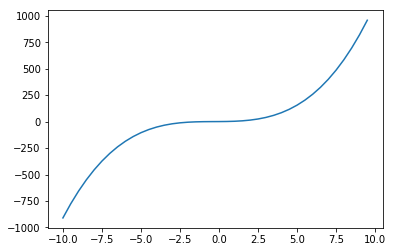

In [3]:
X = np.arange(-10,10, 0.5)
y = target_function(X)
plt.plot(X, y);

## CGP system

In [4]:
import tengp

funset = tengp.FunctionSet()
funset.add(np.add, 2)
funset.add(np.multiply, 2)
funset.add(np.subtract, 2)

In [10]:
params = tengp.Parameters(1, 1, n_columns=50, n_rows=1, function_set=funset)

In [94]:
%%time
res = tengp.evolution_strategy(X.reshape(-1, 1),
                               y,
                               mean_squared_error,
                               params,
                               target_fitness=0,
                               evaluations=10000,
                               verbose=False)

CPU times: user 3.09 s, sys: 0 ns, total: 3.09 s
Wall time: 3.11 s


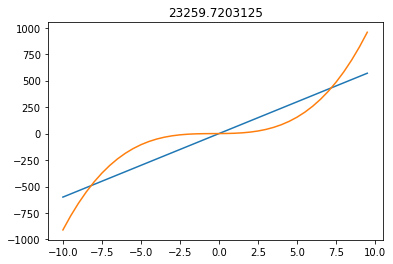

In [95]:
best = res[0]
plt.plot(X , best.transform(X.reshape(-1, 1)))
plt.plot(X, y);
plt.title(best.fitness);

# CMA-ES

In [15]:
ib = tengp.individual.IndividualBuilder(params)

In [18]:
initial_solution = ib.create()

In [20]:
bounds = initial_solution.bounds[:]

In [53]:
def convert(genes):
    """convert float vector from CMA-ES to valid genes vector"""
    processed_genes = []
    for gene, bound in zip(genes, bounds):
        gene = int(round(gene))
        if gene > bound:
            gene = bound
        if gene < 0:
            gene = 0
        processed_genes.append(gene)
    return processed_genes

def cost_function(genes):
    individual = tengp.individual.NPIndividual(convert(genes), bounds, params)
    output = individual.transform(X.reshape(-1,1))
    return (mean_squared_error(output, y),)

In [30]:
from deap import creator
from deap import base

In [31]:
creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', list, fitness=creator.FitnessMin)

In [37]:
from deap import cma
from deap import algorithms
from deap import tools

In [96]:
%%time

strategy = cma.Strategy(centroid=initial_solution.genes, sigma=1)

toolbox = base.Toolbox()
toolbox.register("evaluate", cost_function)

toolbox.register('generate', strategy.generate, creator.Individual)
toolbox.register('update', strategy.update)
hof = tools.HallOfFame(1)
# stats = tools.Statistics(lambda ind: ind.fitness.values)
# stats.register("avg", np.mean)
# stats.register("std", np.std)
# stats.register("min", np.min)
# stats.register("max", np.max)
res = algorithms.eaGenerateUpdate(toolbox, ngen=250, stats=stats, halloffame=hof, verbose=False)

CPU times: user 8.98 s, sys: 109 ms, total: 9.09 s
Wall time: 4.63 s


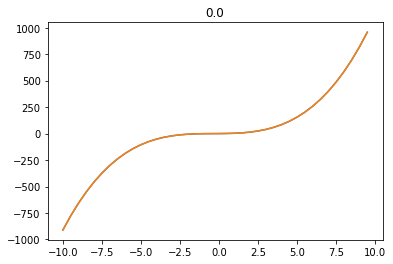

In [97]:
individual = tengp.individual.NPIndividual(convert(hof[0]), bounds, params)
best = individual
output = best.transform(X.reshape(-1,1))
best.fitness = mean_squared_error(y, output)
plt.plot(X, output)
plt.plot(X, y);
plt.title(best.fitness);